In [3]:
%cd daseCV/datasets/
!bash get_datasets.sh
%cd ../..

/home/public/10215501406-1370-161/daseCV/datasets
--2023-09-23 07:30:26--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M   171KB/s    in 39m 29s 

2023-09-23 08:10:05 (70.3 KB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/home/public/10215501406-1370-161


# K-近邻算法 (kNN) 练习

*补充并完成本练习。*

kNN分类器包含两个阶段:

- 训练阶段，分类器获取训练数据并简单地记住它。
- 测试阶段, kNN将测试图像与所有训练图像进行比较，并计算出前k个最相似的训练示例的标签来对每个测试图像进行分类。
- 对k值进行交叉验证

在本练习中，您将实现这些步骤，并了解基本的图像分类、交叉验证和熟练编写高效矢量化代码的能力。

In [1]:
# 运行notebook的一些初始化代码

import random
import numpy as np
from daseCV.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# 使得matplotlib的图像在当前页显示而不是新的窗口。
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 一些更神奇的，使notebook重新加载外部的python模块;
# 参见 http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# 加载未处理的 CIFAR-10 数据.
cifar10_dir = 'daseCV/datasets/cifar-10-batches-py'

# 清理变量以防止多次加载数据（这可能会导致内存问题）
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 作为健全性检查，我们打印出训练和测试数据的形状。
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


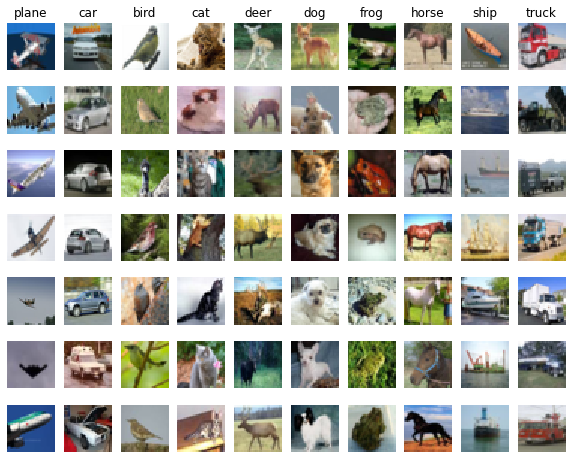

In [3]:
# 可视化数据集中的一些示例。
# 我们展示了训练图像的所有类别的一些示例。
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y) # flatnonzero表示返回所给数列的非零项的索引值，这里表示返回所有属于y类的索引
    idxs = np.random.choice(idxs, samples_per_class, replace=False) # replace表示抽取的样本是否能重复
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# 在练习中使用更小的子样本可以提高代码的效率
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# 将图像数据调整为行
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [5]:
from daseCV.classifiers import KNearestNeighborL1

# 创建一个kNN分类器实例。
# 请记住，kNN分类器的训练并不会做什么： 
# 分类器仅记住数据并且不做进一步处理
classifier = KNearestNeighborL1()
classifier.train(X_train, y_train)

现在，我们要使用kNN分类器对测试数据进行分类。回想一下，我们可以将该过程分为两个步骤： 

1. 首先，我们必须计算所有测试样本与所有训练样本之间的距离。 
2. 给定这些距离，对于每个测试示例，我们找到k个最接近的示例，并让它们对标签进行投票

让我们开始计算所有训练和测试示例之间的距离矩阵。 假设有 **Ntr** 的训练样本和 **Nte** 的测试样本, 该过程的结果存储在一个 **Nte x Ntr** 矩阵中，其中每个元素 (i,j) 表示的是第 i 个测试样本和第 j 个 训练样本的距离。

**注意: 在完成此notebook中的三个距离的计算时请不要使用numpy提供的np.linalg.norm()函数。**

首先打开 `daseCV/classifiers/k_nearest_neighbor.py` 并且补充完成函数 `compute_distances_two_loops` ，这个函数使用双重循环（效率十分低下）来计算距离矩阵。

In [6]:
# 打开 daseCV/classifiers/k_nearest_neighbor_L1.py 并且补充完成
# compute_distances_two_loops.

# 测试你的代码:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


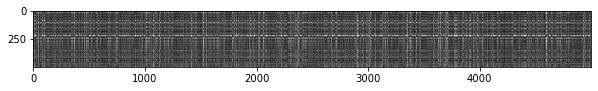

In [8]:
# 我们可视化距离矩阵：每行代表一个测试样本与训练样本的距离
plt.imshow(dists, interpolation='none')
plt.show()

**问题 1** 

请注意距离矩阵中的结构化图案，其中某些行或列的可见亮度更高。（请注意，使用默认的配色方案，黑色表示低距离，而白色表示高距离。）

- 数据中导致行亮度更高的原因是什么？
- 那列方向的是什么原因呢?

$\color{blue}{\textit 答:}$ *- 如果第 i 个测试样本与绝大部分训练样本之间的距离均较大，则第 i 行的可见亮度会更高。*

*- 如果第 j 个训练样本与绝大部分测试样本之间的距离均较大，则第 j 列的可见亮度会更高。*



In [8]:
# 现在实现函数predict_labels并运行以下代码：
# 我们使用k = 1（这是最近的邻居）。
y_test_pred = classifier.predict_labels(dists, k=1)

# 计算并打印出预测的精度
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 145 / 500 correct => accuracy: 0.290000


你预期的精度应该为 `27%` 左右。 现在让我们尝试更大的 `k`, 比如 `k = 5`:

In [9]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 151 / 500 correct => accuracy: 0.302000


你应该能看到一个比 `k = 1` 稍微好一点的结果。

**问题 2**

我们还可以使用其他距离指标，例如L1距离。

记图像 $I_k$ 的每个位置 $(i,j)$ 的像素值为 $p_{ij}^{(k)}$，

所有图像上的所有像素的均值 $\mu$ 为 

$$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$

并且所有图像的每个像素的均值 $\mu_{ij}$ 为

$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$

标准差 $\sigma$ 以及每个像素的标准差 $\sigma_{ij}$ 的定义与之类似。

以下哪个预处理步骤不会改变使用L1距离的最近邻分类器的效果？选择所有符合条件的答案。
1. 减去均值 $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. 减去每个像素均值 $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. 减去均值 $\mu$ 然后除以标准偏差 $\sigma$.
4. 减去每个像素均值 $\mu_{ij}$ 并除以每个素标准差 $\sigma_{ij}$.
5. 旋转数据的坐标轴。

$\color{blue}{\textit 你的回答:}$ *步骤 1、2、3 均不会改变使用L1距离的最近邻分类器的效果。*


$\color{blue}{\textit 你的解释:}$ *对于图像 $I_x$ 和 $I_y$ ，预处理前的L1距离为*
$$dist(I_x,I_y)_{L1}=\sum_{i=1}^{h}\sum_{j=1}^{w}(p_{ij}^{(x)}-p_{ij}^{(y)})$$
1. 减去均值 $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
*经过此预处理步骤后的L1距离为*
$$\begin{align*}
dist(I_x^{'},I_y^{'})_{L1}
&=\sum_{i=1}^{h}\sum_{j=1}^{w}(\tilde{p}_{ij}^{(x)}-\tilde{p}_{ij}^{(y)})\\
&=\sum_{i=1}^{h}\sum_{j=1}^{w}((p_{ij}^{(x)}-\mu)-(p_{ij}^{(y)}-\mu))\\
&=\sum_{i=1}^{h}\sum_{j=1}^{w}(p_{ij}^{(x)}-p_{ij}^{(y)})
\end{align*}$$
*可以发现L1距离在预处理前后未发生改变，所以步骤 1 不会改变使用L1距离的最近邻分类器的效果。*

2. 减去每个像素均值 $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
*经过此预处理步骤后的L1距离为*
$$\begin{align*}
dist(I_x^{'},I_y^{'})_{L1}
&=\sum_{i=1}^{h}\sum_{j=1}^{w}(\tilde{p}_{ij}^{(x)}-\tilde{p}_{ij}^{(y)})\\
&=\sum_{i=1}^{h}\sum_{j=1}^{w}((p_{ij}^{(x)}-\mu_{ij})-(p_{ij}^{(y)}-\mu_{ij}))\\
&=\sum_{i=1}^{h}\sum_{j=1}^{w}(p_{ij}^{(x)}-p_{ij}^{(y)})
\end{align*}$$
*可以发现L1距离在预处理前后未发生改变，所以步骤 2 不会改变使用L1距离的最近邻分类器的效果。*

3. 减去均值 $\mu$ 然后除以标准偏差 $\sigma$.
*经过此预处理步骤后的L1距离为*
$$\begin{align*}
dist(I_x^{'},I_y^{'})_{L1}
&=\sum_{i=1}^{h}\sum_{j=1}^{w}(\tilde{p}_{ij}^{(x)}-\tilde{p}_{ij}^{(y)})\\
&=\sum_{i=1}^{h}\sum_{j=1}^{w}\frac{1}{\sigma}((p_{ij}^{(x)}-\mu)-(p_{ij}^{(y)}-\mu))\\
&=\sum_{i=1}^{h}\sum_{j=1}^{w}\frac{1}{\sigma}(p_{ij}^{(x)}-p_{ij}^{(y)})
\end{align*}$$
*可以发现L1距离在预处理后均仅除以了一个相同的常数 $\sigma$，这不会影响L1距离的比较，所以步骤 3 不会改变使用L1距离的最近邻分类器的效果。*

4. 减去每个像素均值 $\mu_{ij}$ 并除以每个像素标准差 $\sigma_{ij}$.
*经过此预处理步骤后的L1距离为*
$$\begin{align*}
dist(I_x^{'},I_y^{'})_{L1}
&=\sum_{i=1}^{h}\sum_{j=1}^{w}(\tilde{p}_{ij}^{(x)}-\tilde{p}_{ij}^{(y)})\\
&=\sum_{i=1}^{h}\sum_{j=1}^{w}(\frac{1}{\sigma_{ij}}(p_{ij}^{(x)}-\mu_{ij})-\frac{1}{\sigma_{ij}}(p_{ij}^{(y)}-\mu_{ij}))\\
&=\sum_{i=1}^{h}\sum_{j=1}^{w}\frac{1}{\sigma_{ij}}(p_{ij}^{(x)}-p_{ij}^{(y)})
\end{align*}$$
*不妨设 $h=2,w=1$ ，图像 $I_x,I_y,I_z$ 的像素矩阵分别为 $(p_{11}^{(x)},p_{21}^{(x)})^T,(p_{11}^{(y)},p_{21}^{(y)})^T,(p_{11}^{(z)},p_{21}^{(z)})^T$,且$|p_{11}^{(x)}-p_{11}^{(y)}|=1,|p_{21}^{(x)}-p_{21}^{(y)}|=2,|p_{11}^{(x)}-p_{11}^{(z)}|=3,|p_{21}^{(x)}-p_{21}^{(z)}|=1,\sigma_{11}=3,\sigma_{21}=1$，*

*则预处理前的L1距离分别为*
$$dist(I_x,I_y)_{L1}=1+2=3$$
$$dist(I_x,I_z)_{L1}=3+1=4$$

*预处理后的L1距离分别为*
$$dist(I_x^{'},I_y^{'})_{L1}=\frac{1}{3}+\frac{2}{1}=\frac{7}{3}$$
$$dist(I_x^{'},I_z^{'})_{L1}=\frac{3}{3}+\frac{1}{1}=2$$
*可以发现在预处理前图像 $I_x,I_y$ 的L1距离更小，在预处理后图像 $I_x,I_z$ 的L1距离更小，所以步骤 4 会改变使用L1距离的最近邻分类器的效果。*

5. 旋转数据的坐标轴。
*不妨设 $h=2,w=1$ ，图像 $I_x,I_y,I_z$ 的像素矩阵分别为 $(0,0)^T,(1,0)^T,(\frac{\sqrt{2}}{2},\frac{\sqrt{2}}{2})^T$,*

*则预处理前的L1距离分别为*
$$dist(I_x,I_y)_{L1}=1+0=1$$
$$dist(I_x,I_z)_{L1}=\frac{\sqrt{2}}{2}+\frac{\sqrt{2}}{2}=\sqrt{2}$$
*若坐标轴顺时针旋转 $45^{\circ}$，即旋转矩阵为* $R=\begin{pmatrix}
\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} \\
-\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} \\
\end{pmatrix}$

*则图像 $I_x,I_y,I_z$ 的像素矩阵分别变为 $(0,0)^T,(\frac{\sqrt{2}}{2},\frac{\sqrt{2}}{2})^T,(0,1)^T$,*

*则预处理后的L1距离分别为*
$$dist(I_x^{'},I_y^{'})_{L1}=\frac{\sqrt{2}}{2}+\frac{\sqrt{2}}{2}=\sqrt{2}$$
$$dist(I_x^{'},I_z^{'})_{L1}=0+1=1$$
*可以发现在预处理前图像 $I_x,I_y$ 的L1距离更小，在预处理后图像 $I_x,I_z$ 的L1距离更小，所以步骤 5 会改变使用L1距离的最近邻分类器的效果。*

In [7]:
# 现在，通过部分矢量化并且使用单层循环的来加快距离矩阵的计算。
# 需要实现函数compute_distances_one_loop并运行以下代码：

dists_one = classifier.compute_distances_one_loop(X_test)

# 为了确保我们的矢量化实现正确，我们要保证它的结果与最原始的实现方式结果一致。
# 有很多方法可以确定两个矩阵是否相似。最简单的方法之一就是Frobenius范数。 
# 如果您以前从未了解过Frobenius范数，它其实是两个矩阵的所有元素之差的平方和的平方根；
# 换句话说，就是将矩阵重整为向量并计算它们之间的欧几里得距离。

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [8]:
# 现在完成compute_distances_no_loops实现完全矢量化的版本并运行代码
dists_two = classifier.compute_distances_no_loops(X_test)

# 检查距离矩阵是否与我们之前计算出的矩阵一致：
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [ ]:
# 让我们比较一下三种实现方式的速度
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# 你应该会看到使用完全矢量化的实现会有明显更佳的性能！

# 注意：在部分计算机上，当您从两层循环转到单层循环时，
# 您可能看不到速度的提升，甚至可能会看到速度变慢。

Two loop version took 30.125082 seconds
One loop version took 88.742635 seconds


### 交叉验证

我们已经实现了kNN分类器，并且可以设置k = 5。现在，将通过交叉验证来确定此超参数的最佳值。

In [7]:
num_folds = 5
k_choices = [10, 12, 14, 16, 18]

X_train_folds = []
y_train_folds = []
################################################################################
# 需要完成的事情: 
# 将训练数据分成多个部分。拆分后，X_train_folds和y_train_folds均应为长度为num_folds的列表，
# 其中y_train_folds [i]是X_train_folds [i]中各点的标签向量。
# 提示：查阅numpy的array_split函数。                             
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find when running cross-validation.
# 一个字典，存储我们进行交叉验证时不同k的值的精度。
# 运行交叉验证后，k_to_accuracies[k]应该是长度为num_folds的列表，存储了k值下的精度值。
k_to_accuracies = {}


################################################################################
# 需要完成的事情:  
# 执行k的交叉验证，以找到k的最佳值。
# 对于每个可能的k值，运行k-最近邻算法 num_folds 次，
# 在每次循环下，你都会用所有拆分的数据（除了其中一个需要作为验证集）作为训练数据。
# 然后存储所有的精度结果到k_to_accuracies[k]中。                              
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# 交叉验证。有时候，训练集数量较小（因此验证集的数量更小），人们会使用一种被称为
# 交叉验证的方法，这种方法更加复杂些。还是用刚才的例子，如果是交叉验证集，我们就
# 不是取1000个图像，而是将训练集平均分成5份，其中4份用来训练，1份用来验证。然后
# 我们循环着取其中4份来训练，其中1份来验证，最后取所有5次验证结果的平均值作为算
# 法验证结果。

for k in k_choices:
    k_to_accuracies[k] = []
    for i in range(num_folds):
        # prepare training data for the current fold
        X_train_fold = np.concatenate([ fold for j, fold in enumerate(X_train_folds) if i != j ])
        y_train_fold = np.concatenate([ fold for j, fold in enumerate(y_train_folds) if i != j ])
        
        # use of k-nearest-neighbor algorithm
        classifier.train(X_train_fold, y_train_fold)
        y_pred_fold = classifier.predict(X_train_folds[i], k=k, num_loops=2)

        # Compute the fraction of correctly predicted examples
        num_correct = np.sum(y_pred_fold == y_train_folds[i])
        accuracy = float(num_correct) / X_train_folds[i].shape[0]
        k_to_accuracies[k].append(accuracy)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# 打印出计算的精度
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 10, accuracy = 0.289000
k = 10, accuracy = 0.312000
k = 10, accuracy = 0.320000
k = 10, accuracy = 0.323000
k = 10, accuracy = 0.313000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.320000
k = 12, accuracy = 0.324000
k = 12, accuracy = 0.332000
k = 12, accuracy = 0.318000
k = 14, accuracy = 0.294000
k = 14, accuracy = 0.323000
k = 14, accuracy = 0.307000
k = 14, accuracy = 0.328000
k = 14, accuracy = 0.317000
k = 16, accuracy = 0.288000
k = 16, accuracy = 0.329000
k = 16, accuracy = 0.307000
k = 16, accuracy = 0.319000
k = 16, accuracy = 0.314000
k = 18, accuracy = 0.289000
k = 18, accuracy = 0.321000
k = 18, accuracy = 0.307000
k = 18, accuracy = 0.319000
k = 18, accuracy = 0.306000


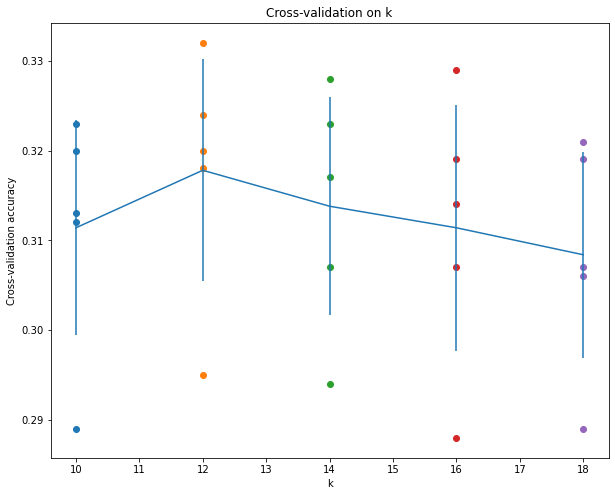

In [8]:
# 绘制原始观察结果
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# 用与标准偏差相对应的误差线绘制趋势线
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [9]:
# 根据上述交叉验证结果，为k选择最佳值，使用所有训练数据重新训练分类器，
# 并在测试中对其进行测试数据。您应该能够在测试数据上获得28％以上的准确性。

best_k = k_choices[accuracies_mean.argmax()]
print(best_k)

classifier = KNearestNeighborL1()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

12
Got 143 / 500 correct => accuracy: 0.286000


**问题 3**

下列关于$k$-NN的陈述中哪些是在分类器中正确的设置，并且对所有的$k$都有效？选择所有符合条件的选项。

1. k-NN分类器的决策边界是线性的。
2. 1-NN的训练误差将始终低于5-NN。
3. 1-NN的测试误差将始终低于5-NN。
4. 使用k-NN分类器对测试示例进行分类所需的时间随训练集的大小而增加。
5. 以上都不是。

$\color{blue}{\textit 你的回答:}$ *选项 2、4 符合条件。*


$\color{blue}{\textit 你的解释:}$ 
1. k-NN分类器的决策边界是线性的。
*因为k-NN是一种非参数方法，并且基于最近邻做出决策，k个最近邻的位置很有可能是任意的，所以k-NN分类器的决策边界通常是非线性的。*

2. 1-NN的训练误差将始终低于5-NN。
*因为在训练集上，对于某个训练样本，1-NN做出的决策始终是选择其本身作为最近邻，所以训练误差通常是零；而5-NN在做出决策时可能会受到噪声或异常值的影响，导致选择的最近邻的标签与自身不一致，从而产生训练误差。所以，1-NN的训练误差将始终低于5-NN。*

3. 1-NN的测试误差将始终低于5-NN。
*因为1-NN可能对训练数据过拟合，从而对噪声或异常值非常敏感，导致在测试集上表现不佳，测试误差可能较高；而5-NN可能因为基于更多的最近邻做出决策，从而具有更平滑的决策边界，受到噪声或异常值的影响较小，测试误差可能较低。所以，1-NN的测试误差并不始终低于5-NN。*

4. 使用k-NN分类器对测试示例进行分类所需的时间随训练集的大小而增加。
*因为训练集越大，对测试示例和训练样本之间距离的计算量就会越大，相应地，对最近邻居的搜索开销也会越大，所以，对测试示例进行分类所需的时间会增加。*

### Data for leaderboard
这里额外提供了一组未给标签的测试集X，用于leaderborad上的竞赛。

---
提示：该题的目的是鼓励同学们探索能够提升模型性能的方法。

In [12]:
# leaderboard的测试数据
X = np.load("./input/X_3072.npy")
################################################################################
# 需要完成的事情: 
# 找到更合适的classifer
# 找到更合适的best_k
# 提示：如果你不想花时间，你也可以直接使用上面已经训练好的classifer和已确定的best_k.                       
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
best_k = 12
classifer_leaderboard = classifier
preds = classifer_leaderboard.predict(X, k=best_k)

提醒：运行完下面代码之后，点击下面的submit，然后去leaderboard上查看你的成绩。本模型对应的成绩在phase1的leaderboard中。

In [13]:
import os
#输出格式
def output_file(preds, phase_id=1):
    path=os.getcwd()
    if not os.path.exists(path + '/output/phase_{}'.format(phase_id)):
        os.mkdir(path + '/output/phase_{}'.format(phase_id))
    path=path + '/output/phase_{}/prediction.npy'.format(phase_id)
    np.save(path,preds)
def zip_fun(phase_id=1):
    path=os.getcwd()
    output_path = path + '/output'
    files = os.listdir(output_path)
    for _file in files:
        if _file.find('zip') != -1:
            os.remove(output_path + '/' + _file)
    newpath=path+'/output/phase_{}'.format(phase_id)
    os.chdir(newpath)
    cmd = 'zip ../prediction_phase_{}.zip prediction.npy'.format(phase_id)
    os.system(cmd)
    os.chdir(path)
output_file(preds)
zip_fun()